#Завантаження бибоиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

In [2]:
# Коефіцієнти для формули
C0 = 2.515_517
C1 = 0.802_853
C2 = 0.010_328
D1 = 1.432_788
D2 = 0.189_265_9
D3 = 0.001_308

class Quantile:

    @classmethod
    def calculate_quantile(cls, p):
        if p > 0.5:
            t = np.sqrt(-2 * np.log(1 - p))
            quantile = (t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))
        else:
            t = np.sqrt(-2 * np.log(p))
            quantile = -(t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))

        return quantile

    @staticmethod
    def student_quantile(p, v):
        up = Quantile.calculate_quantile(p)
        tpv = up + (1 / v) * (1 / 4) * (up ** 3 + up) + (1 / v ** 2) * (1 / 96) * (
            5 * up ** 5 + 16 * up ** 3 + 3 * up) + (1 / v ** 3) * (1 / 384) * (
                  3 * up ** 7 + 19 * up ** 5 + 17 * up ** 3 - 15 * up) + (1 / v ** 4) * (1 / 92_160) * (
                  79 * up ** 9 + 779 * up ** 7 + 1_482 * up ** 5 - 1_920 * up ** 3 - 945 * up)
        return tpv

    @staticmethod
    def fisher_quantile(p ,v1, v2):
        up = Quantile.calculate_quantile(p)

        sigma = 1/v1 + 1/v2
        delta = 1/v1 - 1/v2

        z = (up * np.sqrt(sigma / 2) -
         (1 / 6) * delta * (up**2 + 2) +
         np.sqrt(sigma / 2) * (sigma / 24 * (up**2 + 3 * up) + (1 / 72) * (delta**2 / sigma) * (up**3 + 11 * up)) -
         (sigma * delta / 120) * (up**4 + 9 * up**2 + 8) +
         (delta**3 / (3240 * sigma)) * (3 * up**4 + 7 * up**2 - 16) +
         np.sqrt(sigma / 2) * (sigma**2 / 1920 * (up**5 + 20 * up**3 + 15 * up)) +
         (delta**4 / 2880) * (up**5 + 44 * up**3 + 183 * up) +
         (delta**5 / (155520 * sigma**2)) * (9 * up**5 + 284 * up**3 + 1513 * up)
        )

        return np.exp(2*z)

## 1.Завантаження даних з файлу

In [3]:
path = "../lab5/data_lab1,2/lin0.4.txt"
columns = ['x','y']
delimiter='      ';
df = pd.read_csv(path, delimiter="      ", header=None, names=columns)
print(df.head())

         x        y
0  12.1569  29.5125
1   8.3589  25.7363
2  12.3373  23.6503
3  14.3351  27.5493
4  10.5194  27.1966


C:\Users\Denys\AppData\Local\Temp\ipykernel_20008\2736191813.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter="      ", header=None, names=columns)


### Method for calculating correlation

In [4]:
def pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

#Creating class for calculation quantiles

### Creating class for calculating a Quantitative Characteristics

In [5]:
class QuantitativeCharacteristics:

    def __init__(self,sample):
        self.sample = sample
        self.characteristic_fields_map = ["Mean", "Median", "Std", "Skewness", "Kurtosis", "Min", "Max"]
        self.characteristic_table_dictionary = dict()
        self.mean = None
        self.std_deviation = None
        self.a = None
        self.e = None
        self.sa = None
        self.se = None

    def add_to_dictionary(self, column_name, column_data):
        self.characteristic_table_dictionary.update({column_name: column_data})

    def display(self):
        self.add_characteristics()
        return self.characteristic_table_dictionary

    def add_characteristics(self):
        estimation = self.calculate_estimation()
        self.add_to_dictionary("Characteristic", self.characteristic_fields_map)
        self.add_to_dictionary("Estimation", estimation.keys())
        self.add_to_dictionary("SEM", estimation.values())
        confidence_intervals = self.calculate_confidence_interval(estimation)
        self.add_to_dictionary("95% Confidence Interval", confidence_intervals)

    def calculate_confidence_interval(self, estimation: dict):
        confidence_interval = list(range(0, 7))
        median_conf_interval = self.calculate_median_confidence_interval(list(estimation.keys())[1])
        confidence_interval[1] = f"[{median_conf_interval[0]}; {median_conf_interval[1]}]"
        confidence_interval[5] = "───"
        confidence_interval[6] = "───"

        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(0.95, v)
        print("student_quantile: " + str(student_quantile))
        i = 0
        for key in estimation.keys():
            if (estimation.get(key) == "───"):
                i = i + 1
                continue
            upper_bound = round(key - student_quantile * estimation.get(key), 4)
            lower_bound = round(key + student_quantile * estimation.get(key), 4)
            confidence_interval[i] = f"[{upper_bound}; {lower_bound}]"

            i = i + 1

        return confidence_interval

    def calculate_median_confidence_interval(self, median):
        num_samples = 1000

        bootstrap_samples = [np.random.choice(self.sample, size=len(self.sample), replace=True) for _ in
                             range(num_samples)]

        bootstrap_medians = np.median(bootstrap_samples, axis=1)

        std_error_median = np.std(bootstrap_medians, ddof=1)
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(median - student_quantile * std_error_median, 4)
        upper_bound = round(median + student_quantile * std_error_median, 4)

        return lower_bound, upper_bound

    def calculate_normal_interval(self):
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(self.mean - student_quantile * self.std_deviation, 4)
        upper_bound = round(self.mean + student_quantile * self.std_deviation, 4)
        return lower_bound, upper_bound

    def calculate_estimation(self):
        estimation_map = dict()
        self.mean = round(np.mean(self.sample), 4)
        median = round(np.median(self.sample), 4)
        self.std_deviation = round(np.std(self.sample, ddof=1), 4)
        self.a = round(stats.skew(self.sample), 4)
        self.e = round(stats.kurtosis(self.sample), 4)
        minimum = round(min(self.sample), 4)
        maximum = round(max(self.sample), 4)

        n_len = len(self.sample)
        mean_std = round(self.std_deviation / np.sqrt(n_len), 4)
        std_std_deviation = round(self.std_deviation / np.sqrt(2 * n_len), 4)
        self.sa = round(np.sqrt(6 * n_len * (n_len - 1) / ((n_len - 2) * (n_len + 1) * (n_len + 3))), 4)
        self.se = round(
            np.sqrt(24 * n_len * (n_len - 1) ** 2 / ((n_len - 3) * (n_len - 2) * (n_len + 3) * (n_len + 5))), 4)

        estimation_map[self.mean] = mean_std
        estimation_map[median] = "───"
        estimation_map[self.std_deviation] = std_std_deviation
        estimation_map[self.a] = self.sa
        estimation_map[self.e] = self.se
        estimation_map[minimum] = "───"
        estimation_map[maximum] = "───"
        return estimation_map

## 2.	Побудова кореляційного поля.

Pirson Corelation: 0.4451062953312998


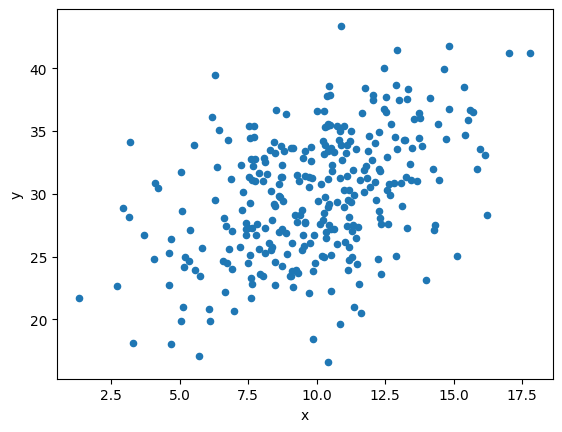

In [6]:
df.plot.scatter(x='x',y='y')
correlation = pearson_correlation(df.loc[:,"x"], df.loc[:,"y"])
print('Pirson Corelation: '+ str(correlation))

# Test

In [8]:
q_c1 = QuantitativeCharacteristics(df['x'])
q_c2 = QuantitativeCharacteristics(df['y'])
res1= pd.DataFrame(q_c1.display())
print(res1)
print('----------')
res2=  pd.DataFrame(q_c2.display())
print(res2)

student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean      9.9243  0.1663       [9.6499; 10.1987]
1         Median     10.2286     ───       [9.8087; 10.6485]
2            Std      2.8801  0.1176         [2.686; 3.0742]
3       Skewness     -0.1256  0.1407       [-0.3578; 0.1066]
4       Kurtosis     -0.0358  0.2805       [-0.4987; 0.4271]
5            Min      1.3277     ───                     ───
6            Max     17.8001     ───                     ───
----------
student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     29.9224  0.2906       [29.4428; 30.402]
1         Median     30.2487     ───      [29.2215; 31.2759]
2            Std      5.0335  0.2055        [4.6944; 5.3726]
3       Skewness     -0.0523  0.1407       [-0.2845; 0.1799]
4       Kurtosis     -0.3814  0.2805       [-0.8443; 0.0815]
5            Min     16.6187     ───                     ───
6 